#**Demers_CS664_FinalProject**

In [1]:
! pip install PyPDF2
! pip -q install boto3
! pip install -U -q PyDrive
! pip install textract
import PyPDF2
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pprint
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import copy
import boto3
import json
import os
import argparse
import textract
import nltk.classify.util
import collections

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import opinion_lexicon
from nltk.corpus.reader import ConllChunkCorpusReader
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import conlltags2tree, tree2conlltags
from nltk.metrics import precision
from nltk.metrics import recall
from nltk.metrics.scores import (precision, recall)
from nltk.classify import NaiveBayesClassifier
nltk.download('averaged_perceptron_tagger')
nltk.download('opinion_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-dat

Read in the PDF file

### Section 1: Read in PDF document

In [0]:
# good preprocessing here:
# https://www.kdnuggets.com/2018/03/simple-text-classifier-google-colaboratory.html

######################################
#NOTE: upload the doc into Colab first
######################################

In [2]:
# using PyPDF2
pdfFileObj = open('/content/fid.pdf', 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
pdfReader.numPages

220

In [0]:
# using PDFminer
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

In [0]:
# NOTE: can spot check pages with this

#pageObj = pdfReader.getPage(0)
#pageObj.extractText()


In [0]:
# put each page into a list
# can analyze each page separately
pages = list()
for i in range(1, pdfReader.numPages):
   pageObj = pdfReader.getPage(i)
   page = pageObj.extractText()
   pages.append(page[0:])

In [4]:
#E01
pages[0]

' \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [0]:
# pdfminer
# NOTE: lose the page ability
converted = convert_pdf_to_txt('/content/fid.pdf')

In [0]:
 type(pages), type(converted)

In [0]:
# remove white space
pages = [n.replace('\n', '') for n in pages]
#converted = [n.replace('\n', '') for n in converted]

In [6]:
len(pages)

219

In [0]:
len(converted)

Create dataframe

In [0]:
# Create dataframe. 
#  NOTE: This will be useful if we want to analyze pages separately.
# Not necessary for this project, but leave it in as may be useful for work project

#page_df = pd.DataFrame({'page': pages})
#converted_df = pd.DataFrame({'page': converted}) # This doesn't work well at all

Create processing file

In [0]:
page_TXT = ''.join(pages)
#converted_TXT = ''.join(converted)

In [0]:
converted_TXT

In [0]:
#############################
# NOTE: conversion from page_TXT to converted_TXT
#############################
# page_TXT = converted_TXT

In [8]:
type(page_TXT)

str

In [0]:
# E02
page_TXT
#make a copy for section 2

page_TXT_copy = copy.deepcopy(page_TXT)

In [0]:
type(page_TXT_copy)

In [0]:
type(pages),  type(page_TXT) #type(page_df)

In [0]:
def Convert(string): 
    li = list(string.split(" ")) 
    return li 

In [0]:
# this step performs the tokenization on the list.

page_TXT = (Convert(page_TXT))

In [12]:
page_TXT

['',
 'In',
 'SpecieIn',
 'Specie(formerly',
 'Fidelity',
 'South-East',
 'Asia',
 'Fund)(formerly',
 'Fidelity',
 'Managed',
 'International',
 'Fund)(formerly',
 'Fidelity',
 'Japan',
 'Special',
 'Situations',
 'Fund)(formerly',
 'Fidelity',
 'UK',
 'Balanced',
 'Fund)(formerly',
 'Fidelity',
 'Income',
 'Plus',
 'Fund)(closed',
 'from',
 '21',
 'June',
 '2019)',
 '(formerly',
 'Fidelity',
 'Sterling',
 'Bond',
 'Fund)',
 '(closed',
 'from',
 '13',
 'May',
 '2016)(formerly',
 'Fidelity',
 'UK',
 'Aggressive',
 'Fund)(formerly',
 'Fidelity',
 'UK',
 'Opportunities',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'UK',
 'Index',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'US',
 'Index',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'World',
 'Index',
 'Fund)',
 '',
 '.',
 '',
 '(Fidelity',
 'MoneyBuilder',
 'Growth',
 'Fund',
 'only)',
 'Financial',
 'TimesFidelity',
 'MoneyBuilder',
 'Growth',
 'Fund',
 'Œ',
 'ISA',
 'class',
 'only:',
 'Market',
 'Indice

###Section 2A: NLP Tool Exploration and Simple Binary Classifier

In [0]:
# This first section is a Binary classifier. This is a trivial approach
# at performing sentiment analysis without following a formal methodology,
# while manually experimenting with various NLP tools. It is not 
# intended to be good; it is just a baseline.

Manual preprocessing

In [0]:
#def remove_punctuation(text):
#  no_punct = "".join([c for c in page_df if c not in string.punctuation])
#  return no_punct

def remove_punctuation(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct  

In [14]:
# E04
# breaking--------- clears page_df
#page_df = page_df.apply(lambda x: remove_punctuation)
#page_TXT = remove_punctuation(page_TXT)
remove_punctuation(page_TXT)

'InSpecieInSpecie(formerlyFidelitySouth-EastAsiaFund)(formerlyFidelityManagedInternationalFund)(formerlyFidelityJapanSpecialSituationsFund)(formerlyFidelityUKBalancedFund)(formerlyFidelityIncomePlusFund)(closedfrom21June2019)(formerlyFidelitySterlingBondFund)(closedfrom13May2016)(formerlyFidelityUKAggressiveFund)(formerlyFidelityUKOpportunitiesFund)(formerlyFidelityMoneyBuilderUKIndexFund)(formerlyFidelityMoneyBuilderUSIndexFund)(formerlyFidelityMoneyBuilderWorldIndexFund)(FidelityMoneyBuilderGrowthFundonly)FinancialTimesFidelityMoneyBuilderGrowthFundŒISAclassonly:MarketIndicesNotetoInvestorsadvaloremadvaloremprorataprorata(formerlyFidelitySouth-EastAsiaFund)Basedonaninformalmonth-endrevaluationoftheFundatmarketcloseonasimilarbasistothatoftheIndex.ThisinformalrevaluationisnotcarriedoutonthesamewayasthevaluationofSharesintheFund,assetinAppendix4e.g.noFairValueorPriceAdjustmentPolicyisapplied.InvestorscannotsubscribeorredeemSharesonthebasisofthisinformalrevaluation.Thisisbecausetheex-pos

In [15]:
page_TXT

['',
 'In',
 'SpecieIn',
 'Specie(formerly',
 'Fidelity',
 'South-East',
 'Asia',
 'Fund)(formerly',
 'Fidelity',
 'Managed',
 'International',
 'Fund)(formerly',
 'Fidelity',
 'Japan',
 'Special',
 'Situations',
 'Fund)(formerly',
 'Fidelity',
 'UK',
 'Balanced',
 'Fund)(formerly',
 'Fidelity',
 'Income',
 'Plus',
 'Fund)(closed',
 'from',
 '21',
 'June',
 '2019)',
 '(formerly',
 'Fidelity',
 'Sterling',
 'Bond',
 'Fund)',
 '(closed',
 'from',
 '13',
 'May',
 '2016)(formerly',
 'Fidelity',
 'UK',
 'Aggressive',
 'Fund)(formerly',
 'Fidelity',
 'UK',
 'Opportunities',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'UK',
 'Index',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'US',
 'Index',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'World',
 'Index',
 'Fund)',
 '',
 '.',
 '',
 '(Fidelity',
 'MoneyBuilder',
 'Growth',
 'Fund',
 'only)',
 'Financial',
 'TimesFidelity',
 'MoneyBuilder',
 'Growth',
 'Fund',
 'Œ',
 'ISA',
 'class',
 'only:',
 'Market',
 'Indice

In [0]:
# create a tokenizer to remove punctuation and make lower case:
# Not needed for page_TXT
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
#page_df = page_df.apply(lambda x: tokenizer.tokenize(x.lower()) for p in page_df)

In [0]:
#page_df

In [0]:
#TODO: convert to lower before removing stop words

In [0]:
# remove the stop words:
# E05
def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words

In [0]:
#page_df = page_df.apply(lambda x: remove_stopwords(x))

In [0]:
# E05
#remove_stopwords(page_TXT)
page_TXT = remove_stopwords(page_TXT)
# this appears to be missing some stopwords
# in case you get the idea again...this separates the text
# into individual letters. Not what we want.
#[remove_stopwords(w) for w  in page_TXT]

In [20]:
page_TXT

['',
 'In',
 'SpecieIn',
 'Specie(formerly',
 'Fidelity',
 'South-East',
 'Asia',
 'Fund)(formerly',
 'Fidelity',
 'Managed',
 'International',
 'Fund)(formerly',
 'Fidelity',
 'Japan',
 'Special',
 'Situations',
 'Fund)(formerly',
 'Fidelity',
 'UK',
 'Balanced',
 'Fund)(formerly',
 'Fidelity',
 'Income',
 'Plus',
 'Fund)(closed',
 '21',
 'June',
 '2019)',
 '(formerly',
 'Fidelity',
 'Sterling',
 'Bond',
 'Fund)',
 '(closed',
 '13',
 'May',
 '2016)(formerly',
 'Fidelity',
 'UK',
 'Aggressive',
 'Fund)(formerly',
 'Fidelity',
 'UK',
 'Opportunities',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'UK',
 'Index',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'US',
 'Index',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'World',
 'Index',
 'Fund)',
 '',
 '.',
 '',
 '(Fidelity',
 'MoneyBuilder',
 'Growth',
 'Fund',
 'only)',
 'Financial',
 'TimesFidelity',
 'MoneyBuilder',
 'Growth',
 'Fund',
 'Œ',
 'ISA',
 'class',
 'only:',
 'Market',
 'Indices',
 'Note',
 'Inv

In [0]:
lemmatizer = WordNetLemmatizer()

In [0]:
def word_lemmatizer(text):
  lem_text = [lemmatizer.lemmatize(i) for i in text]
  return lem_text

In [0]:
# E06
# breaking...---------TypeError: unhashable type: 'list'
#page_df = page_df.apply(lambda x: word_lemmatizer(x))

In [0]:
page_TXT = word_lemmatizer(page_TXT)
#word_lemmatizer(page_TXT)

In [25]:
#page_df
page_TXT

['',
 'In',
 'SpecieIn',
 'Specie(formerly',
 'Fidelity',
 'South-East',
 'Asia',
 'Fund)(formerly',
 'Fidelity',
 'Managed',
 'International',
 'Fund)(formerly',
 'Fidelity',
 'Japan',
 'Special',
 'Situations',
 'Fund)(formerly',
 'Fidelity',
 'UK',
 'Balanced',
 'Fund)(formerly',
 'Fidelity',
 'Income',
 'Plus',
 'Fund)(closed',
 '21',
 'June',
 '2019)',
 '(formerly',
 'Fidelity',
 'Sterling',
 'Bond',
 'Fund)',
 '(closed',
 '13',
 'May',
 '2016)(formerly',
 'Fidelity',
 'UK',
 'Aggressive',
 'Fund)(formerly',
 'Fidelity',
 'UK',
 'Opportunities',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'UK',
 'Index',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'US',
 'Index',
 'Fund)',
 '(formerly',
 'Fidelity',
 'MoneyBuilder',
 'World',
 'Index',
 'Fund)',
 '',
 '.',
 '',
 '(Fidelity',
 'MoneyBuilder',
 'Growth',
 'Fund',
 'only)',
 'Financial',
 'TimesFidelity',
 'MoneyBuilder',
 'Growth',
 'Fund',
 'Œ',
 'ISA',
 'class',
 'only:',
 'Market',
 'Indices',
 'Note',
 'Inv

In [0]:
stemmer = PorterStemmer()

In [0]:
def word_stemmer(text):
  stem_text = " ".join([stemmer.stem(i) for i in text])
  return stem_text

In [0]:
# E07
# breaking: AttributeError: 'list' object has no attribute 'lower'
#page_df = page_df.apply(lambda x: word_stemmer(x))                                             

In [0]:
page_TXT = [stemmer.stem(w) for w in page_TXT]
#[stemmer.stem(w) for w in page_TXT]

In [30]:
#NOTE: The stop word remover
# is not throwing any errors, but is missing some stop words.
page_TXT

['',
 'In',
 'speciein',
 'specie(formerli',
 'fidel',
 'south-east',
 'asia',
 'fund)(formerli',
 'fidel',
 'manag',
 'intern',
 'fund)(formerli',
 'fidel',
 'japan',
 'special',
 'situat',
 'fund)(formerli',
 'fidel',
 'UK',
 'balanc',
 'fund)(formerli',
 'fidel',
 'incom',
 'plu',
 'fund)(clos',
 '21',
 'june',
 '2019)',
 '(formerli',
 'fidel',
 'sterl',
 'bond',
 'fund)',
 '(close',
 '13',
 'may',
 '2016)(formerli',
 'fidel',
 'UK',
 'aggress',
 'fund)(formerli',
 'fidel',
 'UK',
 'opportun',
 'fund)',
 '(formerli',
 'fidel',
 'moneybuild',
 'UK',
 'index',
 'fund)',
 '(formerli',
 'fidel',
 'moneybuild',
 'US',
 'index',
 'fund)',
 '(formerli',
 'fidel',
 'moneybuild',
 'world',
 'index',
 'fund)',
 '',
 '.',
 '',
 '(fidel',
 'moneybuild',
 'growth',
 'fund',
 'only)',
 'financi',
 'timesfidel',
 'moneybuild',
 'growth',
 'fund',
 'Œ',
 'isa',
 'class',
 'only:',
 'market',
 'indic',
 'note',
 'investor',
 'ad',
 'valoremad',
 'valorem',
 'pro',
 'ratapro',
 'rata(formerli',
 'fid

In [0]:
# removing numbers (for now)
def remove(list): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list

In [0]:
# space remover
def remove_space(list): 
    pattern = ''
    list = [re.sub(pattern, '', i) for i in list] 
    return list

In [0]:
#page_TXT = remove(page_TXT)

In [0]:
#remove_space(page_TXT)

Analyze sentiment

In [0]:
# E08
############################
# STOP
############################
# if pysentiment can't be run through pip, we can't use it
# installing from GH puts files in wrong directory in Colab

!pip install pysentiment
#! pip install git+https://github.com/hanzhichao2000/pysentiment
import pysentiment as ps

lm = ps.LM()
#tokens = lm.tokenize(text)
#score = lm.get_score(tokens)
score = lm.get_score(page_TXT)
# https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
# https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386

In [0]:
# parts of speech tagging for each word 
# clean out any empty indexes for this to work
#[x for x in page_TXT if x != '']
page_TXT = [x for x in page_TXT if x != '']

In [0]:
(page_TXT[0:1])

In [0]:
len(page_TXT)

In [0]:
tagg = nltk.pos_tag(page_TXT)

In [34]:
tagg[20:40]

[('fidel', 'NN'),
 ('incom', 'NN'),
 ('plu', 'NN'),
 ('fund)(clos', 'VBZ'),
 ('21', 'CD'),
 ('june', 'NN'),
 ('2019)', 'CD'),
 ('(formerli', 'NN'),
 ('fidel', 'NN'),
 ('sterl', 'NN'),
 ('bond', 'NN'),
 ('fund)', 'NN'),
 ('(close', 'VBD'),
 ('13', 'CD'),
 ('may', 'MD'),
 ('2016)(formerli', 'CD'),
 ('fidel', 'NN'),
 ('UK', 'NNP'),
 ('aggress', 'NN'),
 ('fund)(formerli', 'NN')]

In [0]:
############################
# STOP
############################
# To run on all words, do not run this cell.
# NOTE: takes a long time to run on all text
# Pull the adjectives out of the list
allowed_word_types = ["J"]

In [0]:
# make a list of  all adjectives identified by the allowed word types list above

newtagg = []

for w in tagg:
  if w[1][0] in allowed_word_types:
    newtagg.append(w[0].lower())

In [37]:
newtagg

['speciein',
 'specie(formerli',
 'south-east',
 'intern',
 'special',
 'situat',
 'fund)',
 'moneybuild',
 'financi',
 'moneybuild',
 'isa',
 'indic',
 'valorem',
 'pro',
 'south-east',
 'month-end',
 'close',
 'similar',
 'carri',
 'fund,',
 'e.g.',
 'fair',
 'valu',
 'applied.',
 'basi',
 'ex-post',
 'provid',
 'true',
 'see',
 '(4)',
 'month-end',
 'close',
 'similar',
 'carri',
 'fund,',
 'e.g.',
 'fair',
 'valu',
 'applied.',
 'basi',
 'ex-post',
 'provid',
 'true',
 'see',
 '(4)',
 'month-end',
 'close',
 'similar',
 'carri',
 'fund,',
 'e.g.',
 'fair',
 'valu',
 'applied.',
 'basi',
 'ex-post',
 'provid',
 'true',
 'see',
 '(4)',
 'month-end',
 'close',
 'similar',
 'carri',
 'fund,',
 'e.g.',
 'fair',
 'valu',
 'applied.',
 'basi',
 'ex-post',
 'provid',
 'true',
 'see',
 '(4)',
 'month-end',
 'close',
 'similar',
 'carri',
 'fund,',
 'e.g.',
 'fair',
 'valu',
 'applied.',
 'basi',
 'ex-post',
 'provid',
 'true',
 'see',
 '(4)',
 'month-end',
 'close',
 'similar',
 'carri',
 '

In [38]:
len(newtagg)

130

In [0]:
# determine if the words are positive, negative, or neutral

In [0]:
# https://www.nltk.org/_modules/nltk/sentiment/util.html#demo_liu_hu_lexicon

In [0]:
x = list(range(len(newtagg)))
y = []

In [0]:
pos_words = 0
neg_words = 0

In [0]:
# this takes a few minutes to run
for word in newtagg:
  if word in opinion_lexicon.positive():
    pos_words += 1
    y.append(1)  # positive
  elif word in opinion_lexicon.negative():
    neg_words += 1
    y.append(-1)  # negative
  else:
    y.append(0)  # neutral

In [42]:
if pos_words > neg_words:
  print("Positive")
elif pos_words < neg_words:
  print("Negative")
elif pos_words == neg_words:
  print("Neutral")

Positive


In [43]:
print("positive % of words:", (pos_words/len(newtagg)) * 100)

positive % of words: 5.384615384615385


In [44]:
print("negative % of words:", (neg_words/len(newtagg)) * 100)

negative % of words: 0.0


In [0]:
pw = (pos_words/len(newtagg)) 
nw = (neg_words/len(newtagg)) 

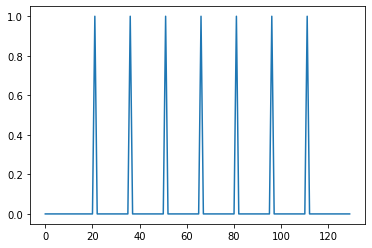

In [52]:
# pick a better plot
plt.plot(x,y)

In [0]:
x

<BarContainer object of 130 artists>

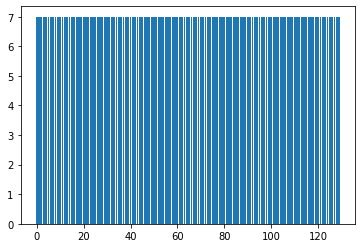

In [53]:
plt.bar(x,sum(y))

In [0]:
# pos = pos/total

Certainty level

In [0]:
# This is a general, trivial binary classifier, and does not have an
#   external source with which to make a comparison. Will not expend effort here.

Named Entity Recognition

In [0]:
# E19
allowed_word_types1 = ['N']
#allowed_word_types1 = ['NNP']

In [55]:
tagg

[('In', 'IN'),
 ('speciein', 'JJ'),
 ('specie(formerli', 'JJ'),
 ('fidel', 'NN'),
 ('south-east', 'JJ'),
 ('asia', 'NN'),
 ('fund)(formerli', 'NN'),
 ('fidel', 'NN'),
 ('manag', 'NN'),
 ('intern', 'JJ'),
 ('fund)(formerli', 'NN'),
 ('fidel', 'NN'),
 ('japan', 'NN'),
 ('special', 'JJ'),
 ('situat', 'JJ'),
 ('fund)(formerli', 'NN'),
 ('fidel', 'NN'),
 ('UK', 'NNP'),
 ('balanc', 'NN'),
 ('fund)(formerli', 'NN'),
 ('fidel', 'NN'),
 ('incom', 'NN'),
 ('plu', 'NN'),
 ('fund)(clos', 'VBZ'),
 ('21', 'CD'),
 ('june', 'NN'),
 ('2019)', 'CD'),
 ('(formerli', 'NN'),
 ('fidel', 'NN'),
 ('sterl', 'NN'),
 ('bond', 'NN'),
 ('fund)', 'NN'),
 ('(close', 'VBD'),
 ('13', 'CD'),
 ('may', 'MD'),
 ('2016)(formerli', 'CD'),
 ('fidel', 'NN'),
 ('UK', 'NNP'),
 ('aggress', 'NN'),
 ('fund)(formerli', 'NN'),
 ('fidel', 'NN'),
 ('UK', 'NNP'),
 ('opportun', 'VBZ'),
 ('fund)', 'JJ'),
 ('(formerli', 'NNP'),
 ('fidel', 'NN'),
 ('moneybuild', 'NN'),
 ('UK', 'NNP'),
 ('index', 'NN'),
 ('fund)', 'VBD'),
 ('(formerli', 'NN

In [0]:
# make a list of  all nouns identified by the allowed word types list above
#This isn't great 
# TODO: fix this

namedEnts = []

for w in tagg:
  if w[1][0] in allowed_word_types1:
    namedEnts.append(w[0].lower())

In [0]:
namedEnts 

### Section 2B: NLTK Sentiment Analysis

In [0]:
# Reference[3] (chapter 7) 

In [0]:
## start with simple text file to get the basics working
#gettysburg = open('/content/GA.txt', 'r')
#gettysburg_str = (gettysburg.read())
#type(gettysburg_str)

In [0]:
#gettysburg_str = ''.join(gettysburg_str)

In [58]:
#type(gettysburg_str), 
type(page_TXT_copy)

str

In [0]:
# P01
#gettysburg_str = nltk.sent_tokenize(gettysburg_str)
page_TXT_copy = nltk.sent_tokenize(page_TXT_copy)

In [0]:
page_TXT_copy

In [0]:
# Word tokenize
#gettysburg_str = [nltk.word_tokenize(sent) for sent in gettysburg_str]
page_TXT_copy = [nltk.word_tokenize(sent) for sent in page_TXT_copy]

In [0]:
#W_T = gettysburg_str

In [0]:
# implement the part of sentence tags:
#gettysburg_str = [nltk.pos_tag(sent) for sent in gettysburg_str]
page_TXT_copy = [nltk.pos_tag(sent) for sent in page_TXT_copy]

In [0]:
#gettysburg_str 

In [0]:
# establish the sentence grammar (can be changed as necessary):
# currently set to: determiner followed by adjective follwed by noun
grammar = "NP: {<DT>?<JJ>*<NN>}"

In [0]:
#gettysburg_str[0]
page_TXT_copy[0]

In [63]:
# apply the grammar rule:
cp = nltk.RegexpParser(grammar)
# the next line (after draw) gets them all
#result = cp.parse(gettysburg_str[0])
result = cp.parse(page_TXT_copy[0])
print(result)

(S
  In/IN
  SpecieIn/NNP
  Specie/NNP
  (/(
  formerly/RB
  Fidelity/NNP
  South-East/NNP
  Asia/NNP
  Fund/NNP
  )/)
  (/(
  formerly/RB
  Fidelity/NNP
  Managed/NNP
  International/NNP
  Fund/NNP
  )/)
  (/(
  formerly/RB
  Fidelity/NNP
  Japan/NNP
  Special/NNP
  Situations/NNP
  Fund/NNP
  )/)
  (/(
  formerly/RB
  Fidelity/NNP
  UK/NNP
  Balanced/NNP
  Fund/NNP
  )/)
  (/(
  formerly/JJ
  Fidelity/NNP
  Income/NNP
  Plus/NNP
  Fund/NNP
  )/)
  (/(
  closed/VBN
  from/IN
  21/CD
  June/NNP
  2019/CD
  )/)
  (/(
  formerly/JJ
  Fidelity/NNP
  Sterling/NNP
  Bond/NNP
  Fund/NNP
  )/)
  (/(
  closed/VBN
  from/IN
  13/CD
  May/NNP
  2016/CD
  )/)
  (/(
  formerly/RB
  Fidelity/NNP
  UK/NNP
  Aggressive/NNP
  Fund/NNP
  )/)
  (/(
  formerly/RB
  Fidelity/NNP
  UK/NNP
  Opportunities/NNP
  Fund/NNP
  )/)
  (/(
  formerly/RB
  Fidelity/NNP
  MoneyBuilder/NNP
  UK/NNP
  Index/NNP
  Fund/NNP
  )/)
  (/(
  formerly/RB
  Fidelity/NNP
  MoneyBuilder/NNP
  US/NNP
  Index/NNP
  Fund/NNP
  )/)


In [0]:
# E18
# plot not working; don't get held up here
# print the first sentence diagram:
#result.draw()
#plt.draw(result)

In [0]:
# build the NLTK tree from the chunked corpus:

page_TXT_copy_comb = []
#gettysburg_comb = []
for sent in page_TXT_copy:
    tree = cp.parse(sent)
    for subtree in tree.subtrees():
      #print(subtree)
      page_TXT_copy_comb.append(subtree)

In [67]:
page_TXT_copy_comb

[Tree('S', [('In', 'IN'), ('SpecieIn', 'NNP'), ('Specie', 'NNP'), ('(', '('), ('formerly', 'RB'), ('Fidelity', 'NNP'), ('South-East', 'NNP'), ('Asia', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('formerly', 'RB'), ('Fidelity', 'NNP'), ('Managed', 'NNP'), ('International', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('formerly', 'RB'), ('Fidelity', 'NNP'), ('Japan', 'NNP'), ('Special', 'NNP'), ('Situations', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('formerly', 'RB'), ('Fidelity', 'NNP'), ('UK', 'NNP'), ('Balanced', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('formerly', 'JJ'), ('Fidelity', 'NNP'), ('Income', 'NNP'), ('Plus', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('closed', 'VBN'), ('from', 'IN'), ('21', 'CD'), ('June', 'NNP'), ('2019', 'CD'), (')', ')'), ('(', '('), ('formerly', 'JJ'), ('Fidelity', 'NNP'), ('Sterling', 'NNP'), ('Bond', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('closed', 'VBN'), ('from', 'IN'), ('13', 'CD'), ('May', 'NNP'), ('

In [0]:
#tree1 = ne_chunk(pos_tag(word_tokenize(gettysburg_str)))
#print(tree1)

In [68]:
# apply the IOB (inside/outside/begin) tags to the tree
iob_tags = tree2conlltags(tree)
print(iob_tags)

[('In', 'IN', 'O'), ('SpecieIn', 'NNP', 'O'), ('Speciein', 'NNP', 'O'), ('specie', 'NN', 'B-NP')]


In [69]:
tree2 = conlltags2tree(iob_tags)
print(tree2)

(S In/IN SpecieIn/NNP Speciein/NNP (NP specie/NN))


In [0]:
# split the data into training/ test set
X = round(len(page_TXT_copy_comb) * .7)

page_TXT_copy_comb_train = page_TXT_copy_comb[:X]
page_TXT_copy_comb_test = page_TXT_copy_comb[(X+1):]

In [0]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [72]:
len(page_TXT_copy_comb)

190

In [0]:
#unigram_chunker = UnigramChunker(gettysburg_comb)

#print(unigram_chunker.evaluate(gettysburg_comb))

In [0]:
# Need to separate the text into training/ test docs
# This is where the pretrained library will come in handy...
#len(gettysburg_comb)
#print(gettysburg_comb[45])

In [0]:
#X = round(len(gettysburg_comb) * .7)

#gettysburg_comb_train = gettysburg_comb[:X]
#gettysburg_comb_test = gettysburg_comb[(X+1):]

In [0]:
#gettysburg_comb_test

In [0]:
#unigram_chunker = UnigramChunker(gettysburg_comb_train)
#print(unigram_chunker.evaluate(gettysburg_comb_test))

In [73]:
len(page_TXT_copy_comb_train), len(page_TXT_copy_comb_test)

(133, 56)

In [74]:
# E09
#unigram_chunker = UnigramChunker(page_TXT_copy_comb_train)
#print(unigram_chunker.evaluate(page_TXT_copy_comb_test))
# the precision/ recall/ F-measure not working

ChunkParse score:
    IOB Accuracy:  81.7%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


In [0]:
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

In [0]:
#bigram_chunker = BigramChunker(gettysburg_comb_train)
#print(bigram_chunker.evaluate(gettysburg_comb_test))

In [76]:
# These numbers aren't great- try to improve
bigram_chunker = BigramChunker(page_TXT_copy_comb_train)
print(bigram_chunker.evaluate(page_TXT_copy_comb_test))

ChunkParse score:
    IOB Accuracy:  86.4%%
    Precision:     60.0%%
    Recall:        13.6%%
    F-Measure:     22.2%%


In [0]:
# can add training classifier code as in section 3.3

In [0]:
# TODO: If time, integrate the following:
# http://kaichen.work/?p=399
# SA which uses Loughran
# Store the lexicon files externally in Colab 
# (like previous project external library)

In [0]:
# Implement Naive Bayes:

In [77]:
classifier = NaiveBayesClassifier.train(page_TXT_copy_comb_train)
print('accuracy:', nltk.classify.util.accuracy(classifier, page_TXT_copy_comb_test))

ValueError: ignored

In [0]:
nltk.metrics.precision(page_TXT_copy_comb_train, page_TXT_copy_comb_test)


###Section 3A: Named Entity Recognition using NLTK

In [0]:
# NOTE: The NLTK version is not working; the SpaCy version is.
# Will focus on SpaCy in order to keep things moving.
# E10

In [78]:
#NER:
#gettysburg_comb
page_TXT_copy_comb

[Tree('S', [('In', 'IN'), ('SpecieIn', 'NNP'), ('Specie', 'NNP'), ('(', '('), ('formerly', 'RB'), ('Fidelity', 'NNP'), ('South-East', 'NNP'), ('Asia', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('formerly', 'RB'), ('Fidelity', 'NNP'), ('Managed', 'NNP'), ('International', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('formerly', 'RB'), ('Fidelity', 'NNP'), ('Japan', 'NNP'), ('Special', 'NNP'), ('Situations', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('formerly', 'RB'), ('Fidelity', 'NNP'), ('UK', 'NNP'), ('Balanced', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('formerly', 'JJ'), ('Fidelity', 'NNP'), ('Income', 'NNP'), ('Plus', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('closed', 'VBN'), ('from', 'IN'), ('21', 'CD'), ('June', 'NNP'), ('2019', 'CD'), (')', ')'), ('(', '('), ('formerly', 'JJ'), ('Fidelity', 'NNP'), ('Sterling', 'NNP'), ('Bond', 'NNP'), ('Fund', 'NNP'), (')', ')'), ('(', '('), ('closed', 'VBN'), ('from', 'IN'), ('13', 'CD'), ('May', 'NNP'), ('

In [0]:
len(page_TXT)

In [0]:
page_TXT

In [0]:
sent  
#print(nltk.ne_chunk(page_TXT), binary = True)

In [0]:
# E12
# will run without the binary argument, but isn't producing results
#print(nltk.ne_chunk(tagg))
print(nltk.ne_chunk(tagg), binary = True)

In [0]:
# E13
# create a list of person, organization and GPE
# 4/29: check this again
entities = ["NE"]

namedEnts = []

for w in tagg:
  if w[1][0] in entities:
    namedEnts.append(w[0].lower())

In [0]:
# after issues getting NLTK NER to work, decided to try SpaCy

###Section 3B: Named Entity Recognition using Spacy

In [0]:
nlp = en_core_web_sm.load()

In [84]:
# somehow went back to list despite deep copy
type(page_TXT_copy)

list

In [0]:
# for some reason the page_TXT_copy switched to list type...keep an eye on this
page_TXT_copy = ''.join(pages)

In [0]:
doc = nlp(page_TXT_copy)

In [87]:
# show the named entities:
([(X.text, X.label_) for X in doc.ents])

[('SpecieIn', 'GPE'),
 ('Fidelity', 'ORG'),
 ('Fidelity Managed International Fund)(formerly', 'ORG'),
 ('Japan', 'GPE'),
 ('21 June 2019', 'DATE'),
 ('Fidelity Sterling Bond Fund', 'ORG'),
 ('13', 'CARDINAL'),
 ('Fidelity UK Opportunities Fund', 'ORG'),
 ('Fidelity MoneyBuilder UK Index Fund', 'ORG'),
 ('Fidelity MoneyBuilder US Index Fund', 'ORG'),
 ('Fidelity MoneyBuilder World Index Fund', 'ORG'),
 ('Fidelity MoneyBuilder Growth Fund', 'ORG'),
 ('Financial TimesFidelity MoneyBuilder Growth Fund Œ ISA', 'ORG'),
 ('Market Indices Note to Investors', 'ORG'),
 ('Fidelity South-East Asia Fund', 'ORG'),
 ('an informal month-end', 'DATE'),
 ('Appendix', 'GPE'),
 ('Price Adjustment Policy', 'ORG'),
 ('Fund', 'ORG'),
 ('4', 'CARDINAL'),
 ('an informal month-end', 'DATE'),
 ('Appendix', 'GPE'),
 ('Price Adjustment Policy', 'ORG'),
 ('Fund', 'ORG'),
 ('4', 'CARDINAL'),
 ('an informal month-end', 'DATE'),
 ('Appendix', 'GPE'),
 ('Price Adjustment Policy', 'ORG'),
 ('Fund', 'ORG'),
 ('4', 'CARD

In [88]:
# The IOB tags
([(X, X.ent_iob_, X.ent_type_) for X in doc])

[( , 'O', ''),
 (In, 'O', ''),
 (SpecieIn, 'B', 'GPE'),
 (Specie(formerly, 'O', ''),
 (Fidelity, 'B', 'ORG'),
 (South, 'O', ''),
 (-, 'O', ''),
 (East, 'O', ''),
 (Asia, 'O', ''),
 (Fund)(formerly, 'O', ''),
 (Fidelity, 'B', 'ORG'),
 (Managed, 'I', 'ORG'),
 (International, 'I', 'ORG'),
 (Fund)(formerly, 'I', 'ORG'),
 (Fidelity, 'O', ''),
 (Japan, 'B', 'GPE'),
 (Special, 'O', ''),
 (Situations, 'O', ''),
 (Fund)(formerly, 'O', ''),
 (Fidelity, 'O', ''),
 (UK, 'O', ''),
 (Balanced, 'O', ''),
 (Fund)(formerly, 'O', ''),
 (Fidelity, 'O', ''),
 (Income, 'O', ''),
 (Plus, 'O', ''),
 (Fund)(closed, 'O', ''),
 (from, 'O', ''),
 (21, 'B', 'DATE'),
 (June, 'I', 'DATE'),
 (2019, 'I', 'DATE'),
 (), 'O', ''),
 ((, 'O', ''),
 (formerly, 'O', ''),
 (Fidelity, 'B', 'ORG'),
 (Sterling, 'I', 'ORG'),
 (Bond, 'I', 'ORG'),
 (Fund, 'I', 'ORG'),
 (), 'O', ''),
 ((, 'O', ''),
 (closed, 'O', ''),
 (from, 'O', ''),
 (13, 'B', 'CARDINAL'),
 (May, 'O', ''),
 (2016)(formerly, 'O', ''),
 (Fidelity, 'O', ''),
 (UK, 

In [89]:
# subtotals
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'CARDINAL': 10, 'DATE': 10, 'FAC': 1, 'GPE': 10, 'ORG': 40})

In [90]:
# most frequent
items = [x.text for x in doc.ents]
Counter(items).most_common(10)
# https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

[('Fund', 8),
 ('an informal month-end', 7),
 ('Appendix', 7),
 ('Price Adjustment Policy', 7),
 ('4', 7),
 ('13', 2),
 ('Shares', 2),
 ('SpecieIn', 1),
 ('Fidelity', 1),
 ('Fidelity Managed International Fund)(formerly', 1)]

In [0]:
# try running on a smaller chunk of the document

#displacy.render(doc, style='dep')

In [91]:
print([(w.text, w.pos_) for w in doc])

[(' ', 'SPACE'), ('In', 'ADP'), ('SpecieIn', 'PROPN'), ('Specie(formerly', 'PROPN'), ('Fidelity', 'PROPN'), ('South', 'PROPN'), ('-', 'PUNCT'), ('East', 'PROPN'), ('Asia', 'PROPN'), ('Fund)(formerly', 'PROPN'), ('Fidelity', 'PROPN'), ('Managed', 'VERB'), ('International', 'PROPN'), ('Fund)(formerly', 'PROPN'), ('Fidelity', 'PROPN'), ('Japan', 'PROPN'), ('Special', 'PROPN'), ('Situations', 'PROPN'), ('Fund)(formerly', 'ADV'), ('Fidelity', 'PROPN'), ('UK', 'PROPN'), ('Balanced', 'PROPN'), ('Fund)(formerly', 'PROPN'), ('Fidelity', 'PROPN'), ('Income', 'PROPN'), ('Plus', 'PROPN'), ('Fund)(closed', 'PROPN'), ('from', 'ADP'), ('21', 'NUM'), ('June', 'PROPN'), ('2019', 'NUM'), (')', 'PUNCT'), ('(', 'PUNCT'), ('formerly', 'ADV'), ('Fidelity', 'PROPN'), ('Sterling', 'PROPN'), ('Bond', 'PROPN'), ('Fund', 'PROPN'), (')', 'PUNCT'), ('(', 'PUNCT'), ('closed', 'VERB'), ('from', 'ADP'), ('13', 'NUM'), ('May', 'PROPN'), ('2016)(formerly', 'NUM'), ('Fidelity', 'PROPN'), ('UK', 'PROPN'), ('Aggressive', 

In [0]:
# Later: put all names entities into DF/ np array
P = len(([(X.text, X.label_) for X in doc.ents if X.label_ == 'PERSON']))
G = len(([(X.text, X.label_) for X in doc.ents if X.label_ == 'GPE']))
O = len(([(X.text, X.label_) for X in doc.ents if X.label_ == 'ORG']))

In [0]:
M = max(P,G,O)

In [0]:
P, G, O

In [0]:
# Don't really need to put into DF- just for formatting

In [0]:
NER = pd.DataFrame(index=range(M),columns=range(3))

In [0]:
# TODO: Get the data into an organized format.

In [0]:
NER['PERSON'] = ([(X.text, X.label_) for X in doc.ents if X.label_ == 'PERSON'])

In [0]:
NER['ORG'] = ([(X.text, X.label_) for X in doc.ents if X.label_ == 'ORG'])

In [0]:
NER['GPE'] = ([(X.text, X.label_) for X in doc.ents if X.label_ == 'GPE'])

*NOT USED*: NLP Using Tensorflow Neural Network

In [0]:
# as my company is going in on AWS, will focus on that solution
# generate version using Tensorflow
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/20_Natural_Language_Processing.ipynb

In [0]:
import tensorflow as tf
from scipy.spatial.distance import cdist

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# If time, can integrate Google BERT here. Will definitely want to try this for work.
# https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

*NOT USED*: NLP Using Amazon Comprehend

In [0]:
# https://colab.research.google.com/github/noahgift/functional_intro_to_python/blob/master/Public_SafariOnline_Day2_Part2.ipynb#scrollTo=bxzeL-i0m2hB

# E14
# Can't get credentials to work

Put keys in local or remote GDrive:  

`cp ~/.aws/credentials /Users/myname/Google\ Drive/awsml/`

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive', force_remount=True)

In [0]:
creds = os.listdir("/content/gdrive/My Drive/awsml")

In [0]:
# create API config
!mkdir -p ~/.aws #&&\

In [0]:
cp -r /content/gdrive/My\ Drive/awsml/credentials ~/.aws/credentials

In [0]:
%pwd

In [0]:
#%cd 'drive'/

In [0]:
#%ls

In [0]:
#%cd 'My Drive'

In [0]:
#%cd awsml/

In [0]:
#%ls

In [0]:
#client = boto3.client('comprehend', region_name='us-east-1')

In [0]:
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = ("/content/gdrive/My Drive/awsml/credentials")

In [0]:
os.environ['AWS_ACCESS_KEY_ID'] = credentials.AWS_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = credentials.AWS_SECRET_ACCESS_KEY

In [0]:
credentials = ("/content/gdrive/My Drive/awsml/credentials")
#ACCESS_KEY = credentials.access_key
#SECRET_KEY = credentials.secret_key

In [0]:
#client = boto3.client(
#    'comprehend',
#    aws_access_key_id=ACCESS_KEY,
#    aws_secret_access_key=SECRET_KEY
#)

In [0]:
client = boto3.client(
    'comprehend',
    #aws_access_key_id=credentials.aws_access_key_id,
    #aws_secret_access_key=credentials.aws_secret_access_key
    region_name='us-east-1'
)

In [0]:
credentials.aws_access_key_id

In [0]:
response = client.detect_dominant_language(
    Text='There is smoke in San Francisco and it makes me angry'
)

In [0]:
# test call

comprehend = boto3.client(service_name='comprehend', region_name="us-east-1")
text = "There is smoke in San Francisco and it makes me angry"
comprehend.detect_sentiment(Text=text, LanguageCode='en')

In [0]:
comprehend = boto3.client(service_name='comprehend', region_name='region')
text = "It is raining today in Seattle" # (swap with docuemnt)

In [0]:
# Detect dominant language
print('Calling DetectDominantLanguage')
print(json.dumps(comprehend.detect_dominant_language(Text = text), sort_keys=True, indent=4))
print("End of DetectDominantLanguage\n")

In [0]:
# detect named entities
print('Calling DetectEntities')
print(json.dumps(comprehend.detect_entities(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectEntities\n')

In [0]:
# detect key phrases
print('Calling DetectKeyPhrases')
print(json.dumps(comprehend.detect_key_phrases(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectKeyPhrases\n')

In [0]:
# detect sentiment
print('Calling DetectSentiment')
print(json.dumps(comprehend.detect_sentiment(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectSentiment\n')

In [0]:
# POS analyzer
print('Calling DetectSyntax')
print(json.dumps(comprehend.detect_syntax(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectSyntax\n')

In [0]:
# Create IAM client
iam = boto3.client('iam')

# Create an access key
response = iam.create_access_key(
    UserName='IAM_USER_NAME'
)

print(response['AccessKey'])

###Section 4: Using Google ML for analysis

In [0]:
# Don't necessarily need this- seems to come preinstalled
#! pip install --upgrade google-cloud-language

In [0]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] =  "/content/drive/My Drive/Google ML/PDF-Analyzer-e0232b0fe41c.json"

In [0]:
page_TXT = ''.join(pages)

In [94]:
# This works....
# ...analyzes all text at once though.

# Instantiates a client
client = language.LanguageServiceClient()

# The text to analyze
# watch page_TXT size
#text = gettysburg_str
text = page_TXT

document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
sentiment = client.analyze_sentiment(document=document).document_sentiment

print('Text: {}'.format(text))
print('Sentiment -> score: {}, magnitude: {}'.format(sentiment.score, sentiment.magnitude))

Text:  In SpecieIn Specie(formerly Fidelity South-East Asia Fund)(formerly Fidelity Managed International Fund)(formerly Fidelity Japan Special Situations Fund)(formerly Fidelity UK Balanced Fund)(formerly Fidelity Income Plus Fund)(closed from 21 June 2019) (formerly Fidelity Sterling Bond Fund) (closed from 13 May 2016)(formerly Fidelity UK Aggressive Fund)(formerly Fidelity UK Opportunities Fund) (formerly Fidelity MoneyBuilder UK Index Fund) (formerly Fidelity MoneyBuilder US Index Fund) (formerly Fidelity MoneyBuilder World Index Fund)  .  (Fidelity MoneyBuilder Growth Fund only) Financial TimesFidelity MoneyBuilder Growth Fund Œ ISA class only: Market Indices Note to Investors ad valoremad valorem pro ratapro rata(formerly Fidelity South-East Asia Fund)          * Based on an informal month-end revaluation of the Fund at market close on a similar basis to that of the Index. This informal revaluation is not carried out on the same way as the valuation of Shares in the Fund, as set

In [0]:
gettysburg_str

In [0]:
gettysburg_str[1]

NOT USED-----START

In [0]:
# This section partially works, but is a work in progress.

In [0]:
# Instantiates a client
client = language.LanguageServiceClient()

In [0]:
# The text to analyze

def details(i):
  #text = gettysburg_str[i]
  text = page_TXT[i]
  document = types.Document(
      content=text,
      type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
  sentiment = client.analyze_sentiment(document=document).document_sentiment
# print:
  print('Text: {}'.format(text))
  print('Sentiment -> score: {}, magnitude: {}'.format(sentiment.score, sentiment.magnitude))
# need to create classifier var & store:
  

In [0]:
details(0)

In [0]:
def sentimentScorer(i):
  #text = gettysburg_str[i]
  text = page_TXT[i]
  document = types.Document(
      content=text,
      type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
  sentiment = client.analyze_sentiment(document=document).document_sentiment
  return sentiment.score

In [0]:
def sentimentMagnitude(i):
  #text = gettysburg_str[i]
  text = page_TXT[i]
  document = types.Document(
      content=text,
      type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
  sentiment = client.analyze_sentiment(document=document).document_sentiment
  return sentiment.magnitude

In [0]:
sentimentMagnitude(6)

In [0]:
df = pd.DataFrame(gettysburg_str)

In [0]:
df.rename(columns={0: "sentence"})

In [0]:
df['Score'] = df.apply(sentiment.score, axis=1)

In [0]:
len(gettysburg_str)
#details(0)

In [0]:
details(0)
#details(1)
#details(6)

In [0]:
# E11
def print_result(annotations):
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude

    for index, sentence in enumerate(annotations.sentences):
        sentence_sentiment = sentence.sentiment.score
        print('Sentence {} has a sentiment score of {}'.format(
            index, sentence_sentiment))

    print('Overall Sentiment: score of {} with magnitude of {}'.format(
        score, magnitude))
    return 0


def analyze(text_to_analyze):
    """Run a sentiment analysis request on text within a passed filename."""
    client = language.LanguageServiceClient()

    with open(text_to_analyze, 'r') as review_file:
        # Instantiates a plain text document.
        content = review_file.read()

    document = types.Document(
        content=content,
        type=enums.Document.Type.PLAIN_TEXT)
    annotations = client.analyze_sentiment(document=document)

    # Print the results
    print_result(annotations)



#analyze(gettysburg_str)

NOT USED-----END

Section 3: Using Google ML to classify text

In [0]:
# https://www.datatonic.com/insights/lets-get-some-structure-into-this-extracting-features-from-free-form-text

In [0]:
language_client = language.LanguageServiceClient()

In [0]:
def show_sentiments(annotations, n):
  score = annotations.document_sentiment.score
  magnitude = annotations.document_sentiment.magnitude
  for index, sentence in enumerate(annotations.sentences[:n]):
    sentence_sentiment = sentence.sentiment.score
    print('Sentence {} has a sentiment score of {:.3f}'.format(index + 1, sentence_sentiment))
    print('Sentence text:\n{}\n'.format(sentence.text.content))
      
  print('Overall Sentiment: score of {:.3f} with magnitude of {:.3f}'.format(
  	score, magnitude))
  return 0 

In [0]:
def show_categories(categories, n):
  for category in categories.categories[:n]:
    print('=' * 20)
    print('name: {}'.format(category.name))
    print('confidence: {:.3f}'.format(category.confidence))

In [0]:
def show_sentences(syntax, n):
  for sentence in syntax.sentences[:n]:
    print('=' * 20)
    print('{}'.format(sentence.text.content))

In [0]:
def show_tokens(syntax, n):
  for token in syntax.tokens[:n]:
    print('=' * 20)
    print('text: {}'.format(token.text.content))
    print('part_of_speech:\n{}'.format(' ' + str(token.part_of_speech).replace('\n', '\n ')))
    print('lemma: {}'.format(token.lemma))

In [0]:
def show_entities(entities, n):
  for entity in entities.entities[:n]:
    print('=' * 20)
    print(' name: {0}'.format(entity.name))
    print(' type: {0}'.format(entity.Type.Name(entity.type)))
    print(' metadata: {0}'.format(dict(entity.metadata)))
    print(' salience: {:.4f}'.format(entity.salience))

In [0]:
def entities_df(n):
  for entity in entities.entities[:n]:
    Ename = entity.name
    Etype = (entity.Type.Name(entity.type))
    Emeta = entity.metadata
    Esal = entity.salience

In [0]:
def show_entity_sentiments(entity_sentiments, n):
  for entity in entity_sentiments.entities[:n]:
    print('=' * 20)
    print(' name: {0}'.format(entity.name))
    print(' type: {0}'.format(entity.Type.Name(entity.type)))
    print(' score: {:.3f}'.format(entity.sentiment.score))
    print(' magnitude: {:.3f}'.format(entity.sentiment.magnitude))

In [0]:
#document = types.Document(content=gettysburg_str, type=enums.Document.Type.PLAIN_TEXT)
document = types.Document(content=page_TXT, type=enums.Document.Type.PLAIN_TEXT)

In [104]:
type(document)

google.cloud.language_v1.types.Document

In [105]:
# E15
categories = language_client.classify_text(document=document)
show_categories(categories, 1)

name: /Finance/Investing
confidence: 0.750


In [0]:
syntax = language_client.analyze_syntax(document)

In [107]:
syntax

sentences {
  text {
    content: "In SpecieIn Specie(formerly Fidelity South-East Asia Fund)(formerly Fidelity Managed International Fund)(formerly Fidelity Japan Special Situations Fund)(formerly Fidelity UK Balanced Fund)(formerly Fidelity Income Plus Fund)(closed from 21 June 2019) (formerly Fidelity Sterling Bond Fund) (closed from 13 May 2016)(formerly Fidelity UK Aggressive Fund)(formerly Fidelity UK Opportunities Fund) (formerly Fidelity MoneyBuilder UK Index Fund) (formerly Fidelity MoneyBuilder US Index Fund) (formerly Fidelity MoneyBuilder World Index Fund)  ."
    begin_offset: -1
  }
}
sentences {
  text {
    content: "(Fidelity MoneyBuilder Growth Fund only) Financial TimesFidelity MoneyBuilder Growth Fund \305\222 ISA class only: Market Indices Note to Investors ad valoremad valorem pro ratapro rata(formerly Fidelity South-East Asia Fund)          * Based on an informal month-end revaluation of the Fund at market close on a similar basis to that of the Index."
    begin

In [108]:
show_sentences(syntax, 5)

In SpecieIn Specie(formerly Fidelity South-East Asia Fund)(formerly Fidelity Managed International Fund)(formerly Fidelity Japan Special Situations Fund)(formerly Fidelity UK Balanced Fund)(formerly Fidelity Income Plus Fund)(closed from 21 June 2019) (formerly Fidelity Sterling Bond Fund) (closed from 13 May 2016)(formerly Fidelity UK Aggressive Fund)(formerly Fidelity UK Opportunities Fund) (formerly Fidelity MoneyBuilder UK Index Fund) (formerly Fidelity MoneyBuilder US Index Fund) (formerly Fidelity MoneyBuilder World Index Fund)  .
(Fidelity MoneyBuilder Growth Fund only) Financial TimesFidelity MoneyBuilder Growth Fund Œ ISA class only: Market Indices Note to Investors ad valoremad valorem pro ratapro rata(formerly Fidelity South-East Asia Fund)          * Based on an informal month-end revaluation of the Fund at market close on a similar basis to that of the Index.
This informal revaluation is not carried out on the same way as the valuation of Shares in the Fund, as set in Appe

In [109]:
show_tokens(syntax, 5)

text: In
part_of_speech:
 tag: ADP
 
lemma: In
text: SpecieIn
part_of_speech:
 tag: NOUN
 number: SINGULAR
 proper: PROPER
 
lemma: SpecieIn
text: Specie
part_of_speech:
 tag: NOUN
 number: SINGULAR
 proper: PROPER
 
lemma: Specie
text: (
part_of_speech:
 tag: PUNCT
 
lemma: (
text: formerly
part_of_speech:
 tag: ADV
 
lemma: formerly


In [0]:
sentiments = language_client.analyze_sentiment(document=document)

In [111]:
show_sentiments(sentiments, 5)

Sentence 1 has a sentiment score of -0.200
Sentence text:
In SpecieIn Specie(formerly Fidelity South-East Asia Fund)(formerly Fidelity Managed International Fund)(formerly Fidelity Japan Special Situations Fund)(formerly Fidelity UK Balanced Fund)(formerly Fidelity Income Plus Fund)(closed from 21 June 2019) (formerly Fidelity Sterling Bond Fund) (closed from 13 May 2016)(formerly Fidelity UK Aggressive Fund)(formerly Fidelity UK Opportunities Fund) (formerly Fidelity MoneyBuilder UK Index Fund) (formerly Fidelity MoneyBuilder US Index Fund) (formerly Fidelity MoneyBuilder World Index Fund)  .

Sentence 2 has a sentiment score of -0.200
Sentence text:
(Fidelity MoneyBuilder Growth Fund only) Financial TimesFidelity MoneyBuilder Growth Fund Œ ISA class only: Market Indices Note to Investors ad valoremad valorem pro ratapro rata(formerly Fidelity South-East Asia Fund)          * Based on an informal month-end revaluation of the Fund at market close on a similar basis to that of the Index

0

Named Entitiy Recognition with Google ML

In [0]:
entities = language_client.analyze_entities(document=document)

In [113]:
# Show 5 entities:
show_entities(entities, 5)

 name: revaluation
 type: OTHER
 metadata: {}
 salience: 0.5352
 name: way
 type: OTHER
 metadata: {}
 salience: 0.1066
 name: Shares
 type: OTHER
 metadata: {}
 salience: 0.0402
 name: timing
 type: OTHER
 metadata: {}
 salience: 0.0337
 name: valuation
 type: OTHER
 metadata: {}
 salience: 0.0334


In [0]:
entity_sentiments = language_client.analyze_entity_sentiment(document=document)

In [115]:
show_entity_sentiments(entity_sentiments, 5)

 name: revaluation
 type: OTHER
 score: 0.000
 magnitude: 0.400
 name: way
 type: OTHER
 score: 0.000
 magnitude: 1.600
 name: Shares
 type: OTHER
 score: 0.000
 magnitude: 2.700
 name: timing
 type: OTHER
 score: 0.000
 magnitude: 0.000
 name: valuation
 type: OTHER
 score: -0.100
 magnitude: 0.700


In [0]:
# work this out if time
# E20
entitiesDF = pd.DataFrame()

In [0]:
#entitiesDF= entities_df(entities)

In [0]:
#type(document)
#df = pd.DataFrame(document)
# result: google.cloud.language_v1.types.Document ; not the way to go
#type(gettysburg_str)

# need to read in with each line as row entry

#df = pd.DataFrame(gettysburg_str)

In [0]:
page_TXT = nltk.sent_tokenize(page_TXT)

In [0]:
#gettysburg_str1 = nltk.sent_tokenize(gettysburg_str)

In [0]:
#type(gettysburg_str1)

In [0]:
# convert to DF
#df = pd.DataFrame(gettysburg_str1)
df = pd.DataFrame(page_TXT)

In [121]:
df.head

<bound method NDFrame.head of                                                     0
0    In SpecieIn Specie(formerly Fidelity South-Ea...
1   (Fidelity MoneyBuilder Growth Fund only) Finan...
2   This informal revaluation is not carried out o...
3   no Fair Value or Price Adjustment Policy is ap...
4   Investors cannot subscribe or redeem Shares on...
5   This is because the ex-post tracking error cal...
6                           See (4) Valuation timing.
7   * Based on an informal month-end revaluation o...
8   This informal revaluation is not carried out o...
9   no Fair Value or Price Adjustment Policy is ap...
10  Investors cannot subscribe or redeem Shares on...
11  This is because the ex-post tracking error cal...
12                          See (4) Valuation timing.
13  * Based on an informal month-end revaluation o...
14  This informal revaluation is not carried out o...
15  no Fair Value or Price Adjustment Policy is ap...
16  Investors cannot subscribe or redeem Shares on..

In [0]:
# use this approach prior to running large document
#mini_df = df[:10]

In [0]:
df = df.rename(columns={0: "content"})

In [123]:
print("<{}>".format(df.columns[0]))

<content>


Finalize Dataset

In [0]:
# E15
def get_category(content):
  document = types.Document(content=content, type=enums.Document.Type.PLAIN_TEXT)
  categories = language_client.classify_text(document=document)
  return ', '.join([c.name for c in categories.categories])

In [125]:
type(df)

pandas.core.frame.DataFrame

In [0]:
# E17
#######################
# STOP
#######################
 #ERROR: 400 Invalid text content: too few tokens (words) to process.

#mini_df_categories = mini_df.content.apply(get_category)
#mini_df['categories'] = mini_df_categories
df_categories = df.content.apply(get_category)
df['categories'] = df_categories
#

In [0]:
#content = gettysburg_str
content = page_TXT
def get_sentiment_scores(content):
  #document = types.Document(content=content, type=enums.Document.Type.PLAIN_TEXT)
  document = types.Document(content=content, type=enums.Document.Type.PLAIN_TEXT)
  sentiments = language_client.analyze_sentiment(document=document)
  score = sentiments.document_sentiment.score
  magnitude = sentiments.document_sentiment.magnitude
  return pd.Series([score, magnitude])

In [128]:
type(content)

list

In [0]:
#mini_df

In [0]:
#mini_df = mini_df.rename(columns={0: 'content'})

In [0]:
# E16
#mini_df.shape
#mini_df_sentiment_scores = mini_df.content.apply(get_sentiment_scores)
df_sentiment_scores = df.content.apply(get_sentiment_scores)

In [0]:
#mini_df_sentiment_scores = pd.DataFrame(mini_df_sentiment_scores)
#mini_df_sentiment_scores.columns = ['score', 'magnitude']
#mini_df = pd.concat([mini_df, mini_df_sentiment_scores], axis=1)
df_sentiment_scores = pd.DataFrame(df_sentiment_scores)
df_sentiment_scores.columns = ['score', 'magnitude']
df = pd.concat([df, df_sentiment_scores], axis=1)

In [131]:
df

,content,score,magnitude
0,In SpecieIn Specie(formerly Fidelity South-Ea...,-0.2,0.2
1,(Fidelity MoneyBuilder Growth Fund only) Finan...,-0.2,0.2
2,This informal revaluation is not carried out o...,-0.2,0.2
3,no Fair Value or Price Adjustment Policy is ap...,0.0,0.0
4,Investors cannot subscribe or redeem Shares on...,-0.2,0.2
5,This is because the ex-post tracking error cal...,-0.8,0.8
6,See (4) Valuation timing.,0.1,0.1
7,* Based on an informal month-end revaluation o...,0.0,0.0
8,This informal revaluation is not carried out o...,-0.2,0.2
9,no Fair Value or Price Adjustment Policy is ap...,0.0,0.0


In [0]:
def get_top_entities(content):
  document = types.Document(content=content, type=enums.Document.Type.PLAIN_TEXT)
  entities = language_client.analyze_entities(document=document)
  return ', '.join([e.name for e in entities.entities[:5]])

In [133]:
#top_entities = mini_df.content.apply(get_top_entities)
#mini_df['entities'] = top_entities
#mini_df.head()
top_entities = df.content.apply(get_top_entities)
df['entities'] = top_entities
df.head()

,content,score,magnitude,entities
0,In SpecieIn Specie(formerly Fidelity South-Ea...,-0.2,0.2,"Fidelity, Fidelity South-East Asia Fund, Speci..."
1,(Fidelity MoneyBuilder Growth Fund only) Finan...,-0.2,0.2,"Fidelity MoneyBuilder Growth Fund, revaluation..."
2,This informal revaluation is not carried out o...,-0.2,0.2,"revaluation, way, valuation, Shares, Fund"
3,no Fair Value or Price Adjustment Policy is ap...,0.0,0.0,"Fair Value, Price Adjustment Policy"
4,Investors cannot subscribe or redeem Shares on...,-0.2,0.2,"Investors, Shares, basis, revaluation"


In [0]:
def label_sent(row):
   if row['score'] >= .5 :
      return 'P'
   if row['score'] <= -.5 :
      return 'N'
   return 'X'

In [0]:
df['sentiment'] = df.apply(lambda row: label_sent(row), axis=1)

In [136]:
df 

,content,score,magnitude,entities,sentiment
0,In SpecieIn Specie(formerly Fidelity South-Ea...,-0.2,0.2,"Fidelity, Fidelity South-East Asia Fund, Speci...",X
1,(Fidelity MoneyBuilder Growth Fund only) Finan...,-0.2,0.2,"Fidelity MoneyBuilder Growth Fund, revaluation...",X
2,This informal revaluation is not carried out o...,-0.2,0.2,"revaluation, way, valuation, Shares, Fund",X
3,no Fair Value or Price Adjustment Policy is ap...,0.0,0.0,"Fair Value, Price Adjustment Policy",X
4,Investors cannot subscribe or redeem Shares on...,-0.2,0.2,"Investors, Shares, basis, revaluation",X
5,This is because the ex-post tracking error cal...,-0.8,0.8,"way, tracking error, midday valuation, FundTM,...",N
6,See (4) Valuation timing.,0.1,0.1,"Valuation, timing, 4",X
7,* Based on an informal month-end revaluation o...,0.0,0.0,"revaluation, Fund, market close, basis, Index",X
8,This informal revaluation is not carried out o...,-0.2,0.2,"revaluation, way, valuation, Shares, Fund",X
9,no Fair Value or Price Adjustment Policy is ap...,0.0,0.0,"Fair Value, Price Adjustment Policy",X


In [0]:
# Accuracy/ certainty level

In [0]:
# Don't run yet


# https://cloud.google.com/automl-tables/docs/evaluate
# TODO(developer): Uncomment and set the following variables
project_id = 'pdf-analyzer-1587656397865'
# compute_region = 'COMPUTE_REGION_HERE'
# model_display_name = 'MODEL_DISPLAY_NAME_HERE'
# filter_ = 'filter expression here'

from google.cloud import automl_v1beta1 as automl

client = automl.TablesClient(project=project_id, region=compute_region)

# List all the model evaluations in the model by applying filter.
response = client.list_model_evaluations(
    model_display_name=model_display_name, filter_=filter_
)

print("List of model evaluations:")
for evaluation in response:
    print("Model evaluation name: {}".format(evaluation.name))
    print("Model evaluation id: {}".format(evaluation.name.split("/")[-1]))
    print(
        "Model evaluation example count: {}".format(
            evaluation.evaluated_example_count
        )
    )
    print("Model evaluation time:")
    print("\tseconds: {}".format(evaluation.create_time.seconds))
    print("\tnanos: {}".format(evaluation.create_time.nanos))
    print("\n")

Next steps:

In [0]:
##############
# NEXT STEPS:
##############
# 1. Need to integrate BERT now that the DF is working; compare the sentiment
#     using the BERT pretrained corpus
# 2. implement precision, recall, etc. of BERT implementation



###Section 4: Using Google BERT for text classification